# Corrective RAG (CRAG)
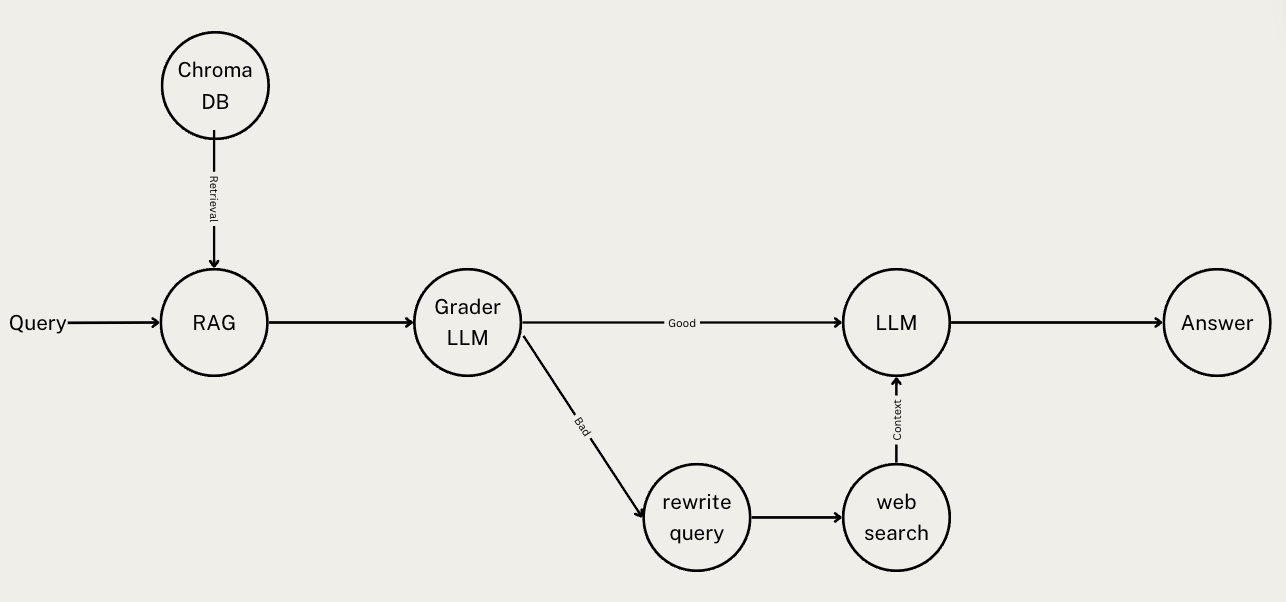

# Enviorment 

In [ ]:
# Installing necessary packages for the project
# langchain_community: Used for accessing community features in the LangChain library
# tiktoken: A token management tool for language models
# langchain-openai: Provides an interface to OpenAI's APIs for LangChain
# langchainhub: Central hub for LangChain resources
# chromadb: A database solution tailored for LangChain applications
# langchain: Main library for building and managing language models
# langgraph: For constructing and manipulating language graphs
# tavily-python: A library for managing and visualizing language model outputs
# sentence-transformers: Framework for sentence and text embeddings using Transformer models

%pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph tavily-python
%pip install sentence-transformers
%pip install -q -U google-generativeai


### LLMs

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

### Search
 
[Tavily Search](https://python.langchain.com/docs/integrations/tools/tavily_search) for web search.

In [3]:
TRAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
os.environ['TRAVILY_API_KEY'] = TRAVILY_API_KEY

### Tracing

Optionally, use [LangSmith](https://docs.smith.langchain.com/) for tracing.

In [4]:
LANGCHAIN_TRACING_V2 = os.getenv('LANGCHAIN_TRACING_V2')
LANGCHAIN_ENDPOINT = os.getenv('LANGCHAIN_ENDPOINT')
LANGCHAIN_API_KEY = os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = LANGCHAIN_TRACING_V2
os.environ['LANGCHAIN_ENDPOINT'] = LANGCHAIN_ENDPOINT
os.environ['LANGCHAIN_API_KEY'] = LANGCHAIN_API_KEY

## Index
 
Let's index 3 blog posts.

In [59]:
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer

tokenizer = AutoTokenizer.from_pretrained("WhereIsAI/UAE-Large-V1")

# Define a function to use Sentence Transformers for embeddings
class SentenceTransformersEmbeddings:
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model = SentenceTransformer(model_name)
    
    def embed_documents(self, texts):
        return self.model.encode(texts, show_progress_bar=True)
    def embed_query(self, query):
        return self.model.encode([query], show_progress_bar=False)[0]

website_data_path = '/Users/mrinoybanerjee/Desktop/Duke/Classes/Spring 2024/AIPI 590 - LLM/Fine-tuned-AIPI-FAQ-Chatbot/raw_website_data'

docs_list = []
for filename in os.listdir(website_data_path):
    file_path = os.path.join(website_data_path, filename)
    if os.path.isfile(file_path):
        with open(file_path, 'r') as f:
            docs_list.append(f.read())
            
# Initialize the text splitter with the specified chunk size and overlap
text_splitter = CharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer, chunk_size=1000, chunk_overlap=50
)

# Split the loaded documents into smaller chunks
# Since `split_documents` function is not directly shown in the provided context,
# assuming a function that accepts a list of documents and splits each accordingly
documents = [text_splitter.split_text(doc) for doc in docs_list]

# Flatten the list of lists into a single list of documents
flattened_documents = [chunk for doc_chunks in documents for chunk in doc_chunks]

vectorstore = Chroma.from_texts(
    texts = flattened_documents, 
    collection_name="aipi-faq",
    embedding=OpenAIEmbeddings(),
)

retriever = vectorstore.as_retriever()
print("Embeddings created!")



Embeddings created!


## LLMs

In [60]:
### Retrieval Grader 

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

# LLM with function call 
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt 
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "What technical electives do I have to take as a part of the AIPI program?"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [61]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

As part of the AIPI program, you have to take technical electives such as Optimization in Practice (AIPI 530) and Deep Reinforcement Learning Applications (AIPI 531). Additionally, you can choose from other graduate-level elective courses within Duke's Pratt School of Engineering with instructor permission. At least one elective must be taken through the AI MEng program.


In [62]:
### Question Re-writer

# LLM 
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# Prompt 
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying sematic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Here is the initial question: \n\n {question} \n Formulate an improved question."),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What are the required technical electives for the AIPI program?'

## Web Search Tool

In [63]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

# Graph 

Capture the flow in as a graph.

## Graph state

In [64]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents 
    """
    question : str
    generation : str
    web_search : str
    documents : List[str]

In [65]:
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}
    
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

### Edges

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

## Build Graph

The just follows the flow we outlined in the figure above.

In [66]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

In [68]:
from pprint import pprint

# Run
inputs = {"question": "What technical electives are offered in the AIPI program?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('The technical electives offered in the AIPI program are AIPI 530: '
 'Optimization in Practice and AIPI 531: Deep Reinforcement Learning '
 'Applications. These courses focus on optimization in artificial intelligence '
 'and deep reinforcement learning applications, providing students with '
 'essential skills in these areas. Students can also take other graduate-level '
 "elective courses within Duke's Pratt School of Engineering with instructor "
 'permission.')


In [71]:
from pprint import pprint

# Run
inputs = {"question": "How many students will be a part of my cohort?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('The expected number of students in your cohort can vary depending on the '
 'specific context and purpose of the cohort. Cohorts can range from small '
 'peer-based units to entire grade levels of students. It is important to '
 'consider the goals of the cohort and the level of individual attention you '
 'can provide when determining the number of students.')
